In [ ]:
# preamble

# set up environments base -> ATOMIC_GOES
# IJulia and Revise must be installed in the Julia base @version package environment.
# Sometimes perhaps an vscode extension
using Revise # does using Revise first allow for revising code in ATOMIC_GOES???
using Pkg
# Pkg.activate(joinpath(homedir(), "Projects/ATOMIC/ATOMIC_GOES/julia/ATOMIC_GOES"))
Pkg.activate(".")

# using ATOMIC_GOES
# using ATOMIC_GOES.DataIO

using Printf
# using FileIO
using Dates
using NCDatasets
using JLD2

# using StatsBase
using ForwardDiff
using Statistics
using Interpolations
# using DSP

using PyPlot
# using PyCall
# using CSV

  Activating project at `~/Projects/ATOMIC/ATOMIC_GOES/julia/RHB/sonde`


In [ ]:
# utility functions; extend matplotlib

# use numpy masking for missing
using PyCall
using PyCall: PyObject

# allow for plotting with missing values
function PyObject(a::Array{Union{T,Missing},N}) where {T,N}
    numpy_ma = PyCall.pyimport("numpy").ma
    pycall(numpy_ma.array, Any, coalesce.(a,zero(T)), mask=ismissing.(a))
end

"plotf(f, x, args...)  function plot wrapper"
plotf(f, x, args...) = plot(f.(x), x, args...)

pd = permutedims

"midpoint averager"
mid(x) = 0.5*(x[1:end-1].+x[2:end]) # doesn't work for Int16

"missing to zero"
# m2z(x) = ismissing(x) ? 0 : x
m2z(x) = replace(x, missing=>0)

# statistics fcns
"anomaly"
anom(r, kwargs...) = r .- mean(r, kwargs...)

"runningmean(x, n=7, f=isfinite) n-point running mean points satisfying f(x)==true"
function runningmean(x, n=7, f=isfinite)
    notf2zero(x) = f(x) ? x : 0
    cs = cumsum(notf2zero.(x))
    ct = cumsum(f.(x))
    (cs[n+1:end] .- cs[1:end-n]) ./ (ct[n+1:end] .- ct[1:end-n])
end

recurse(f, x, n) = n>0 ? f(recurse(f, x, n-1)) : x
"abstractly composes f n times; recursef(f,3) = f∘f∘f = x->f(f(f(x))), without evaluating"
recursef(f,n) = reduce(∘, ntuple(_ -> f, n)) 

"declare arrays with elements of Union{Missing,T} unions"
similarmissing(s::Tuple, T::Type=Float64) = Array{Union{Missing, T}}(missing, s)
similarmissing(A::Array) = similarmissing(size(A), eltype(A))

"moving_average(A, m) m-point moving average of A"
function moving_average(A::AbstractArray, m::Int, cond=x->true)
    out = similar(A)
    R = CartesianIndices(A)
    Ifirst, Ilast = first(R), last(R)
    I1 = m÷2 * oneunit(Ifirst)
    for I in R
        n, s = 0, zero(eltype(out))
        for J in max(Ifirst, I-I1):min(Ilast, I+I1)
            if cond(A[J]) # add condition, e.g. isfinite
                s += A[J]
                n += 1
            end
        end
        out[I] = s/n
    end
    return out
end

moving_average

In [ ]:
module VaporSat

using ForwardDiff

export qsat, dqsdT, dlnqsdT
export Twet_autodiff

# constants
Cp = 1005.7  # from my Davies-Jones function, was 1005.
Cpv = 1870.0 # J/kg/K
Cw  = 4190.0
L0 = 2.501e6 # J/kg

C = 273.15 # K
Rd = 287.04
Rv = 461.5
RdoRv=Rd/Rv

"latent heat of water vapor"
LvK(TempK) = L0 + (Cpv-Cw) * (TempK-273.0)

# functions
"""
es(T,p) = is saturation vapor pressure based on Wexler's formula,
with enhancement factor for moist air rather than water vapor.
The enhancement factor requires a pressure.
T [degrees C], p [Pa] (note the reversed input order), es [Pa]
Calling with optional keywords changes the units and
ignores the positional arguments.
es(T,p; TK=tk[Kelvin], P=pr[hPa])
From A. L. Buck 1981: JAM, 20, 1527-1532.
SPdeS 7 July 2004
"""
function es(T,p=1e5; P=p*1e-2)
    esat = 1e2 * 6.1121*(1.0007 + 3.46e-8*P)*exp((17.502*T)/(240.97 + T)) # convert es to Pa
end

"T [C]; supplying TK [Kelvin] by keyword ignores positional T"
function es(T,p=1e5; TK=T+C, P=p*1e-2)
    T = TK - C
    esat = 1e2 * 6.1121*(1.0007 + 3.46e-8*P)*exp((17.502*T)/(240.97 + T)) # converts es to Pa
end

"""
qsat(p,T) is saturation specific humidity based on Wexler's formula for es
with enhancement factor (see es.m).
p [Pa], T [degrees C], qsat [kg/kg]
From A. L. Buck 1981: JAM, 20, 1527-1532.
SPdeS 7 July 2004
"""
qsat(p,T) = RdoRv*es(T,p) / (p + (RdoRv-1)*es(T,p))

"dqsdT(p,T[C]) derivative of qsat with respect to T at p,T by autodiff of Bolton's qsat"
dqsdT(p,T) = ForwardDiff.derivative(t -> qsat(p,t), T)
dlnqsdT(p,T) = ForwardDiff.derivative(t -> log(qsat(p,t)), T)

# wet bulb temperature methods
# for approximating the evap process

"General single Newton iteration to update x toward f(x) = fhat for a univariate function f"
updatex(f, x, fhat) = x + (fhat-f(x)) / ForwardDiff.derivative(f, x)

"""
Twet_autodiff(T[K], q[kg/kg], p[Pa]; niter=2) wet bulb temperature using Newton's method
for target specific humidity q[kg/kg]. Uses automatic differntiation.
"""
function Twet_autodiff(T, q, p; niter=2)
    f(t) = (t - T) + LvK((T+t)/2)/Cp * (qs(p,t-C) - q)
    t=T
    for i in 1:niter
        t = updatex(f, t, 0)
    end
    t
end
# 2 iterations converges to ~0.001 K

# call as...
# q = rh*qsat(pa, Ta)
# Twet_autodiff(Ta, rh*qsat(pa, Ta-C), pa) 

end # module VaporSat

┌ Warning: Replacing docs for `Main.VaporSat.es :: Union{Tuple{Any}, Tuple{Any, Any}}` in module `Main.VaporSat`
└ @ Base.Docs docs/Docs.jl:243


Main.VaporSat

In [ ]:
# functions for thermodynamics

using .VaporSat
# exports dqsdT
# overloads some methods in VaporSat

# constants
Rd=287.04 # J/K/kg Bolton
Cp=1005.7 # J/K/kg Bolton
Rv=461.5 # Bolton
# specific heats of vapor and liquid
Cpv=1870 # Bolton
Cw=4190  # Bolton
gravity=9.8 #
KelvinCelsius=273.15 # K


# Lv(T) = 2.501e6 + (Cpv-Cw) * T # Celsius
"Lv(T) [J/kg] Latent heat of vaporization of water as a function of temperature [K]."
Lv(T) = 2.501e6 + (Cpv-Cw) * (T-KelvinCelsius)

"""
qv(p/ev) = Rd / (Rv * (p/ev + (Cp/Rv-1)))
specific humidity [kg/kg]
"""
qv(poev) = Rd / (Rv * (poev + (Cp/Rv-1.)))
qv(p,ev) = qv(p/ev)

"vapor pressure in units of p, qv unitless"
ev(p, qv) = p*qv / (Rd/Rv + qv)

"""
esat(T,p) [hPa] computes saturation vapor pressure based on Wexler's formula,
with enhancement factor for moist air rather than water vapor.
The enhancement factor requires a pressure.
T [degrees C], p [hPa] (note the reversed input order), es [hPa]
From A. L. Buck 1981: JAM, 20, 1527-1532.
SPdeS 7 July 2004
"""
esat(T, p) = 6.1121*(1.0007 + 3.46e-8*p)*exp((17.502*T)/(240.97 + T))
#              hPa

# use method from VaporSat qsat(p[Pa], T[C])
# note order of arguments and units
# "qsat(T[C], p[hPa])"
# qsat(T, p) = qv(p/esat(T, p))

"specific humidity q [unitless] from mixing ratio w [unitless]"
q_from_w(w) = w/(1+w)

"""
Tlcl(T[K], ev[Pa])
Temperature at the LCL [K]. From Bolton, 1980, MWR, 108, 1046-1053.
"""
Tlcl(T, ev) = 2840. / (3.5*log(T) - log( 0.01*ev ) - 4.805) + 55.

# adiabatic lapse rate
lapse_ad = gravity/Cp

"moist adiabatic lapse rate p[Pa], T[K]"
lapse_moist(T,p) = lapse_ad * (1 + Lv(T)*qsat(p,T-KelvinCelsius)/(Rd*T)) / (1 + Lv(T)^2*Rd/Rv*qsat(p,T-KelvinCelsius)/(Rd*Cp*T*T))
# lapse_moist(T,p) = lapse_ad * (1 + Lv(T)*qsat(T-273.0,p)/(Rd*T)) / (1 + Lv(T)^2*Rd/Rv*qsat(T-273.0,p)/(Rd*Cp*T*T))

"parcel process adiabatic change in saturation vapor pressure, p[Pa], T[K]"
dqsatdz_moistad(p,T) = dqsdT(p,T-KelvinCelsius) * -lapse_moist(T,p) # negative
# Small inconsistencies between dqsdT (Bolton) 
# and lapse_moist (Rogers and Yau) methods
# are OK here.

dqsatdz_moistad

In [ ]:
# load data

# prefixer() = startswith(gethostname(), "sundog") ? "/mnt/c" : "/"
# datapath = joinpath(prefixer(), "Users/deszoeks/Data/ATOMIC/radiosonde/level2")
datapath = "./data"

# PSL flux data file
# EUREC4A_ATOMIC_RonBrown_10min_nav_met_sea_flux_20200109-20200212_v1.3.nc
psl = NCDataset(joinpath(datapath, "EUREC4A_ATOMIC_RonBrown_10min_nav_met_sea_flux_20200109-20200212_v1.3.nc"))
# mean(skipmissing(psl["hl_bulk"][:]))
# mean(skipmissing(psl["prate"][:])) # 0.031 mm/h

# E0 = -mean(skipmissing(psl["hl_bulk"][:])) # 180 W/m^2
# P0 = rhosfc*L * mean(skipmissing(psl["prate"][:])) / 3600 # W/m^2

# sondes data file
datapath = joinpath(homedir(),"Data/ATOMIC/radiosonde/level2")
# readdir(datapath)
ncfile = filter(x-> startswith(x,"EUREC4A_RonBrown") && endswith(x,"Vaisala-RS_L2_v3.0.0.nc"), readdir(datapath))
ds = NCDataset( joinpath(datapath, ncfile[1]) )

ds[:alt][:] # 3100, 10-m vert resolution
ds[:ta][:,:] # 3100×277 Matrix{Union{Missing, Float32}}
# p(sounding, alt) ;
# lat(sounding, alt) ;
# lon(sounding, alt) ;
# dz(sounding, alt) ;
# ta(sounding, alt) ;
# dp(sounding, alt) ;
# wspd(sounding, alt) ;
# u(sounding, alt) ;
# v(sounding, alt) ;
# mr(sounding, alt) ;
# theta(sounding, alt) ;
# q(sounding, alt) ;
# wdir(sounding, alt) ;
# rh(sounding, alt) ;
# N_ptu(sounding, alt) ;
# N_gps(sounding, alt) ;

# ncdump -h EUREC4A_Atalante_Vaisala-RS_L2_v2.2.0.nc | grep -o -e "float \(\w*\)" | awk '{print $2}'
floatvars = split("p lat lon dz ta dp wspd u v mr theta q wdir rh N_ptu N_gps")
ncfile[1]

"EUREC4A_RonBrown_Vaisala-RS_L2_v3.0.0.nc"

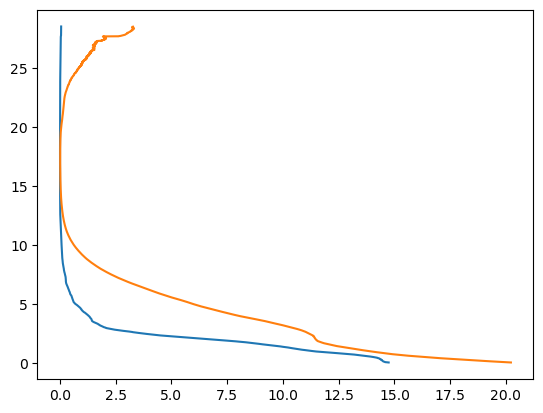

In [ ]:
"average all sounding times. preserve levels"
tmean(var, ds=ds) = [mean(skipmissing(ds[var][i,:])) for i in axes(ds[var][:,:],1)]

# get mean sounding data
z = ds[:alt][:]
tam = tmean(:ta) # K
thm = tmean(:theta)
qm  = tmean(:q)
pm  = tmean(:p) # Pa
qs  = qsat.(pm, tam.-KelvinCelsius) # kg/kg

# plot potential temperature
clf()
[ plot(ds[:theta][:,i], z/1e3, color="c", linewidth=0.2) for i in axes(ds[:theta][:,:],2) ]
plot(thm, z/1e3, color="tab:blue")
ylim(0, 4)
xlim(295, 320)
title("potential temperature (K)")
gcf()

clf()
plot(qm*1e3, z/1e3) # g/kg
plot(qs*1e3, z/1e3)
gcf()

In [ ]:
# profile and parameters for cloud & flux model control case
ae = 1.5e-3
x = 0.7 # was 0.25
# pcp_coeff = x*ae # 1/m
# entr_coeff = (1-x) * ae

# vertical grid
z = ds[:alt][:]
ii = findall(isfinite.(qm))

divg = 1.0e-6 # 1/s
zi = 3.0e3    # m
Δq = qs .- qm # depends on environment only

# vertical velocity (m/s)
subsidence(z; divg=divg, zi=zi) = -min(z,zi) * divg # <0

# derivatives
dz = 10.0
dqdz  = diff(tmean(:q)) / dz
dqsdz = diff( qs      ) / dz
qm = tmean(:q)
z = ds[:alt][:]
ii = findall(isfinite.(qm))
wdqdz = subsidence.(z[1:end-1]) .* dqdz
# ^ negate on rhs
# cumsum( wdqdz[ii] ) * dz / (Δq*(1-epsilon))

# total large scale drying, add advection term in lower atm
A = -wdqdz .- 1.7e-8*max.(0, (4e3.-z[1:end-1])/4e3) 

# set up prototype mass flux calculation

#=
# L = 2.4e6
rhosfc = 1.16 # kg/m^2

ztop=4e3
# Tm = mean(skipmissing(tmean(:ta)[ds[:alt][:].<=ztop])); # mean Cu layer temperature
n2m(x) = isnan(x) ? missing : x
skipnan(x) = skipmissing(n2m.(x))
# vertical means over the cloud layer
Tmean = mean(skipnan(tmean(:ta)[ds[:alt].<=ztop])) # 286.6K = mean Cu layer temperature
pmean = mean(skipnan(tmean(:p)[ds[:alt].<=ztop]))
L = Lv(Tmean)
rhoL = pmean/(Rd*Tmean) * L

E0 = -mean(skipmissing(psl["hl_bulk"][:])) # 180 W/m^2
P0 = rhosfc*L * mean(skipmissing(psl["prate"][:])) / 3600 # -> 25 W/m^2
=#

# set flux, vertical coordinate
zcb= = 700 # cloud base height m
icb = findfirst(z.>=zcb) # cloud base index

Ecb = 145 # this satisfies the condition that 
Fcb = Ecb/rhoL - mean(skipmissing(psl["prate"][:])) / 3600 # total flux at cloud base
# F[icb] = Fcb # total flux at cloud base
# integrate total flux balancing subsidence
F = similarmissing(qm)

# F[icb:end] = Fcb .+ vcat(0, cumsum( A[icb:end] ) * dz)
# Aideal = -1.7e-8 .* min.(1, exp.(-(z.-2.7e3)./500))

In [ ]:
# cloud base initial condition
zcb = 700
icb = findfirst(z .>= zcb)
qcb = qs[icb] # 0.0157

ist = findfirst(z .>= 2000)
ien = findfirst(z .<= 5000)

"terminate the cloud at ql=0"
findcloudtop(ql) = findfirst(ql .== 0 .&& z .> zcb )

"terminate the cloud either at ql=0 or at the elevated minimum ql in the trade inversion"
function findcloudtop(ql, ist,ien)
    itop = findfirst(ql .== 0 .&& z .> zcb )
    if isnothing(itop) # choose the minimum 
        itop = argmin(ql[ist:ien]) + ist - 1
    end
    itop
end

Fcld = similarmissing(F)
# parameter ranges
pcp_effic = 0:0.02:0.9         # precipitation efficiency
tot_sink  = 5e-4 : 1e-4 : 5e-3 # total sink rate α+ϵ
Pcb  = NaN .+ zeros(length(pcp_effic), length(tot_sink))
ztop = NaN .+ zeros(length(pcp_effic), length(tot_sink))
for ix in eachindex(pcp_effic)
    qtilde = q_tilde(qm, qs, x)
    for ia in eachindex(tot_sink)
        x  = pcp_effic[ix]
        ae = tot_sink[ia]
        # compute clouds
        qt = q_total(dz*ae, x, qs, qm; i0=icb, qt0=qcb)
        ql = max.(0, qt.-qs)
        # itop = findlast(ql .> 0)
        itop = findcloudtop(ql)
        if !isnothing(itop)
            ztop[ix,ia] = z[itop]
            Pcb[ix,ia] = precipflux_down_sfc(x, ae, F, ql, qt, qm, istart=itop, icb=icb)
        end
    end
end

In [ ]:
# compute total flux F

# cloud base vapor flux initial condition
Ecb = 145 # E0 - 35; just the cloud vapor flux
Fcb = Ecb/rhoL - mean(skipmissing(psl["prate"][:])) / 3600 # _total_ flux F at cloud base
# F[icb] = Fcb # total flux at cloud base
# integrate total flux balancing subsidence
F = similarmissing(qm)
# A = -wdqdz .- 1.7e-8*max.(0, (4e3.-z[1:end-1])/4e3) # as above
F[icb:end] = Fcb .+ vcat(0, cumsum( A[icb:end] ) * dz)
# F[icb] == Fcb # test
# trade cu top
# minfindfirst(F.<0)

# precipitation efficiency found iteratively to make F=Fcld=P=0 at ztop
# x=0.39

# icb = findfirst(.!ismissing.(F))
itop=lastindex(F)-1 


3099

# cloud model

In [ ]:
# updraft total water and cloud water functions
# Updraft q_total, ql do not depend on F or Fcld.
# Below, mass flux W depends on q_total and Fcld.

# define parameters that functions depend on
# entrainment, autoconversion, and precipitation efficiency
# ae = 1.5e-3
# x = 0.39
# entr_coeff = (1-x) * ae
# pcp_coeff = x * ae

"qtilde=(1-x)*qm .+ x*qs intermediate environmental moisture function"
function q_tilde(qm, qs, x)
    (1-x)*qm .+ x*qs
end

"updraft q_total function"
function q_total(aedz, x, qs, qm; i0, qt0, stopattop=false)
    qtilde=(1-x)*qm .+ x*qs
    qt = copy(qtilde)
    qt[1:i0] .= qt0 # cloud base initial condition
    # in cloud
    for i in i0:length(qt)-1
        if qt[i] > qs[i] # in cloud
            a = aedz
            Q = 0.5*(qtilde[i]+qtilde[i+1])
            qt[i+1] = ((1-0.5*a)*qt[i] + a*Q) / (1+0.5*a)
        elseif !stopattop   # above cloud
            a = (1-x)*aedz  # no precipitation sink
            Q = 0.5*(qm[i]+qm[i+1])
            qt[i+1] = ((1-0.5*a)*qt[i] + a*Q) / (1+0.5*a)
        elseif stopattop  # above cloud, stop at cloud top
            qt[i+1] = -999
        end
    end
    return qt
end

# cloud flux Fcld functions
# ql needs to be calculate by the cloud functions already
"""
Iterates up cloud flux modifying Fcld with precipitation efficiency x and total flux F.
Must initialize cloud base Fcld[icb] first!
"""
function cloudflux!(Fcld, x, ae, F, ql, qt, qm, icb=icb, itop=min(lastindex(F),findfirst(.!ismissing.(F) .&& F.<0)+20))
    Δq = qt .- qm
    c = @. -x*ae * ql / Δq * dz/2 # Q*dz stepping quantity # /2 added 2025 Aug 16
    # step Fcld through the trade Cu layer
    for i in icb:itop
        Fcld[i+1] = (F[i+1]-F[i] + Fcld[i]*(1+c[i])) / (1-c[i+1])                
    end
end

"integrate precipitation down to cloud base by stepping"
function precipflux_down_sfc(x, ae, F, ql, qt, qm; istart=maximum(findall(ql.>0))+1, icb=icb)
    c = @. x*ae * ql/(2*(qt-qm)) * dz
    #P[istart] = 0.0
    P = 0.0 # at cloud top istart
    for i in (istart-1):-1:icb
        # update P by 1 step
        # P[i] = ( (1+c[i+1])*P[i+1] + c[i]*F[i] + c[i+1]*F[i+1] ) / ( 1-c[i] )
        P = ( (1+c[i+1])*P + c[i]*F[i] + c[i+1]*F[i+1] ) / ( 1-c[i] )
    end
    return P # at cloud base
end

"precipitation profile integrated downward from cloud top"
function precipflux_down(x, ae, F, ql, qt, qm; istart=maximum(findall(ql.>0))+1, icb=icb)
    c = @. x*ae * ql/(2*(qt-qm)) * dz
    #P[istart] = 0.0
    P = zeros(size(F)) # at cloud top istart
    for i in (istart-1):-1:icb
        # update P by 1 step
        P[i] = ( (1+c[i+1])*P[i+1] + c[i]*F[i] + c[i+1]*F[i+1] ) / ( 1-c[i] )
      # P    = ( (1+c[i+1])*P      + c[i]*F[i] + c[i+1]*F[i+1] ) / ( 1-c[i] )
    end
    P[1:icb-1] = NaN
    return P # precip flux vector
end

q_total

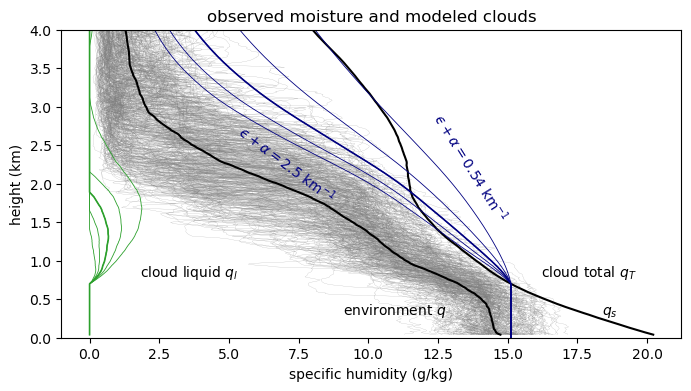

In [ ]:
# compute, plot best q_T, ql for control case
# some experimentation is done below

# parameters
ae = 1.5e-3
x = 0.43
entr_coeff = (1-x) * ae
pcp_coeff = x * ae
icb = findfirst(z .>= 700)

# qcb = 0.016 # cloud base initial condition
qcb = qs[icb] # 0.01568
qtilde = q_tilde(qm, qs, x)
# qtilde[1:54] .= qcb # cloud base initial condition
qt = q_total(dz*ae, x, qs, qm; i0=icb, qt0=qcb, qtilde=qtilde)
ql = max.(0, qt.-qs)

# plot result of cloud model
clf()
[ plot(1e3*ds[:q][:,i], z[:]/1e3, color="tab:gray", linewidth=0.1) for i in axes(ds[:q][:,:],2) ]
plot(1e3*qm, z/1e3, label=L"q", color="k")
plot(1e3*qs, z/1e3, label=L"q_s", color="k")
#for ae = 5e-3 .* (0.5:-0.1:0.1)
aeplot = vcat(5.4e-4, 1e-3 : 5e-4 : 2.5e-3)
for ae = aeplot
    qt_=q_total(dz*ae, x, qs, qm; i0=icb, qt0=qcb, qtilde=qtilde)
    plot(1e3*qt_, z/1e3, label="α+ϵ=$(1e3*ae) km\$^{-1}\$", color="navy",linewidth=0.6)
    plot(1e3*max.(0,qt_.-qs), z/1e3, color="tab:green", linewidth=0.6)
end
# plot control case
plot(1e3*qt, z/1e3, label="α+ϵ=$(1e3*ae) km\$^{-1}\$", color="navy",linewidth=1.2)
plot(1e3*ql, z/1e3, color="tab:green", linewidth=1.2)
ylim([0, 4])
ylabel("height (km)")
title("observed moisture and modeled clouds")#\nfor different entrainment\nand autoconversion sinks")
# legend(frameon=false)
xlabel("specific humidity (g/kg)")
text( 1.8, 0.8, "cloud liquid \$q_l\$")
text(16.2, 0.8, "cloud total \$q_T\$")
text( 9.1  , 0.3, "environment \$q\$")
text(18.4, 0.3, "\$q_s\$")
# annotate cloud sink rates
text(12.2, 1.5, L"ϵ+α="*"$(aeplot[1]*1e3) km"*L"^{-1}", color="navy", rotation=-58)
text( 5.2, 1.75, L"ϵ+α="*"$(aeplot[end]*1e3) km"*L"^{-1}", color="navy", rotation=-37)

# [ savefig("moisture_clouds.$(f)", format=f) for f in ("eps","png","svg","pdf") ]
gcf()

In [ ]:
# isotope model

# isotope parameters
# const Rvsmow = 1 # will work relatively for defining R-delta reln., but not absolute
const RDvsmow = 155.76e-6 # unitless, deuterium
const R18Ovsmow = 2005.2e-6 # unitless, oxygen-18

delt(R, Rvsmow=RDvsmow) = 1e3*(R/Rvsmow - 1) # permil
Rati(d, Rvsmow=RDvsmow) = Rvsmow * (1 + d*1e-3); # d in permil

# alpha equilibrium functions
# define alpha within code scope to assume D or 18O
"equilibrium fractionation ratio for deuterium alpha(T[Kelvin]) = [HDO]/[H2O]"
alphae_d(T) = exp( 1158.8e-12 .*T.^3 - 1620.1e-9 .*T.^2 + 794.84e-6 .*T - 161.04e-3 + 2.9992e6./T.^3 )

"equilibrium fractionation ratio for oxygen-18 alpha(T[Kelvin]) = [H2 18O]/[H2 16O]"
alphae_18o(T) = exp( -7.685e-3 + 6.7123 ./T - 1.6664e3 ./T.^2 + 0.35041e6 ./T.^3 )

1.3323905631586862e61

In [ ]:

# compute isotope ratio for total cloud vapor + liquid with
# entrainment and precipitation autoconversion
function ddz_q_iso_cloud(qit, qienv, qil, ϵ, ρ)
    # qit = total cloud isotope ratio
    # qienv = environmental isotope ratio
    # qi_l = liquid isotope ratio
    # ϵ = entrainment rate
    # ρ = precipitation autoconversion rate
    return dqidz = ϵ * (qienv .- qit) - ρ * qil
end

# used below
# RTcld = qiTcld/qTcld
# Rvcld = RTcld / ((1-α)*qv/qt + α)
# qilcld = α * Rvcld * qlcld

UndefVarError: UndefVarError: `qiTcld` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [ ]:
function step_Rt(qenv, qt, qv, T, Renv, Rt, ϵ, ρ, dz)
    # qenv = environmental specific humidity
    # qt = total cloud specific humidity
    # qv = cloud vapor specific humidity
    # T = temperature
    # Renv = environmental isotope ratio
    # Rt = total cloud isotope ratio
    # ϵ = entrainment rate
    # ρ = precipitation autoconversion rate
    # α = equilibrium fractionation factor
    # dz = vertical step size
    αT = alphae_d(T) # Kelvin
    Rv = Rt / ((1-αT)*qv/qt + αT)
    qit = Rt * qt
    qienv = Renv * qenv
    qil = αT * Rv * qv

    # predictor step
    dqidz = ϵ * (qienv - qit) - ρ * qil
    qi_mid = qit + dqidz * 0.5 * dz
    # corrector step
    dqidz = ϵ * (qienv - qi_mid) - ρ * qil
    qi_new = qit + dqidz * dz
    
    Rt_new = qi_new / qt
    return Rt_new
end

qenv = q
qv = qt .- ql
Renv = similar(q)
Rt = similar(q)

# approx isotope ratios from Bailey et al. 2022 Fig. 9, 13
deltad(z) = ( z <= 2e3  ?  -70.0 -  10.0*(height    )/1e3 : 
              z <= 5e3  ?  -90.0 -  80.0*(height-2e3)/1e3 :
              z <= 10e3 ? -330.0 - 200.0*(height-5e3)/1e3 )
Renv = Rati(deltad)

Rt[1] = Renv[1] # initial condition:
for i in 1:length(qt)-1
    # midpoint values for step
    qenvm = 0.5 * (qenv[i] + qenv[i+1])
    qtm = 0.5 * (qt[i] + qt[i+1])
    qvm = 0.5 * (qv[i] + qv[i+1])
    Tm = 0.5 * (T[i] + T[i+1])
    Renvm = 0.5 * (Renv[i] + Renv[i+1])
    Rt[i+1] = step_Rt(qenvm, qtm, qvm, Tm, Renvm, Rt[i], ϵ, ρ, dz)
end